In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
%matplotlib inline

In [ ]:
import sys
sys.path.append('./llm-transparency-tool')

from llm_transparency_tool.models.tlens_model import TransformerLensTransparentLlm
from llm_transparency_tool.models.transparent_llm import ModelInfo
from llm_transparency_tool.routes.graph import GraphBuilder, build_full_graph, build_paths_to_predictions

from src.utils import obtain_all_ice_variants, evaluate, load_model_and_tokenizer
from src.information_flow_routes import generate_graphs, take_operators_operands_nodes_from_contribution_graphs, plot_information_flow_graphs

import networkx as nx
import random
import torch
import numpy as np

seed = 0
random.seed(seed)
torch.manual_seed(seed)
torch.set_grad_enabled(False)

device = "cuda" if torch.cuda.is_available() else "cpu"

MODEL_NAME = "meta-llama/Llama-3.1-8B"
DATASET
TAU_THRESHOLD = 0.04

### Load the model and the dataset

In [3]:
tokenizer, model = load_model_and_tokenizer(MODEL_NAME, device)
model_information_flow = TransformerLensTransparentLlm(
    model_name=MODEL_NAME,
    device='gpu'
)
dataset = torch.load('./data/llama_3_data.pt')

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Llama-3.1-8B into HookedTransformer


In [16]:
dataset

[([(('268', '417', '189', '874'), '268+417+189=874. '),
   (('426', '86', '75', '587'), '426+86+75=587. '),
   (('135', '768', '3', '906'), '135+768+3=906. '),
   (('123', '620', '123', '866'), '123+620+123=866. '),
   (('204', '284', '85', '573'), '204+284+85=573. ')],
  ('26', '52', '604', '682'),
  '26+52+604=',
  '({x}+{y}+{z})'),
 ([(('33', '332', '112', '477'), '33+332+112=477. '),
   (('461', '234', '72', '767'), '461+234+72=767. '),
   (('211', '30', '461', '702'), '211+30+461=702. '),
   (('42', '161', '376', '579'), '42+161+376=579. '),
   (('312', '82', '183', '577'), '312+82+183=577. ')],
  ('246', '114', '556', '916'),
  '246+114+556=',
  '({x}+{y}+{z})'),
 ([(('365', '23', '327', '715'), '365+23+327=715. '),
   (('54', '251', '196', '501'), '54+251+196=501. '),
   (('456', '50', '50', '556'), '456+50+50=556. '),
   (('410', '169', '177', '756'), '410+169+177=756. '),
   (('759', '184', '36', '979'), '759+184+36=979. ')],
  ('244', '501', '223', '968'),
  '244+501+223=',
 

### Preprocess the dataset

In [4]:
dataset_no_ice, dataset_single_ice, dataset_two_ice, dataset_all_ice = obtain_all_ice_variants(dataset)

### Evaluate the model on the dataset

In [5]:
results_no_ice, results_single_ice, results_two_ice, results_all_ice = [evaluate(tokenizer, model, data, batch_size=10, prepend_bos=True) for data in [dataset_no_ice, dataset_single_ice, dataset_two_ice, dataset_all_ice]]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [6]:
results = [results_no_ice, results_single_ice, results_two_ice, results_all_ice]
print("Results (No ICE, Single ICE, Two ICE, All ICE):", [np.round(np.mean(res), 3) for res in results])

Results (No ICE, Single ICE, Two ICE, All ICE): [0.303, 0.747, 0.753, 0.8]


### Obtain information flow graphs

In [ ]:
information_flow_graphs = generate_graphs(model_information_flow, dataset_single_ice, results_single_ice, threshold=TAU_THRESHOLD)

  0%|          | 0/300 [00:00<?, ?it/s]

2025-11-03 18:43:14.995 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-03 18:43:15.105 
  command:

    streamlit run /home/eickhoff/esx208/.conda/envs/icl_mech_interp/lib/python3.9/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-11-03 18:43:15.106 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-03 18:43:15.106 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2025-11-03 18:43:15.609 Thread 'Thread-6': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-03 18:43:15.615 Thread 'Thread-6': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-03 18:43:33.025 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-03 18:43:33.025 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Loaded pretrained model meta-llama/Llama-3.1-8B into HookedTransformer


### Obtain from all graphs nodes related to operands, operators, and the result token

In [10]:
information_flow_graphs_main_nodes = take_operators_operands_nodes_from_contribution_graphs(information_flow_graphs, tokenizer)

### Plot information flow graphs

/home/eickhoff/esx208/.conda/envs/icl_mech_interp/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


  0%|          | 0/224 [00:00<?, ?it/s]

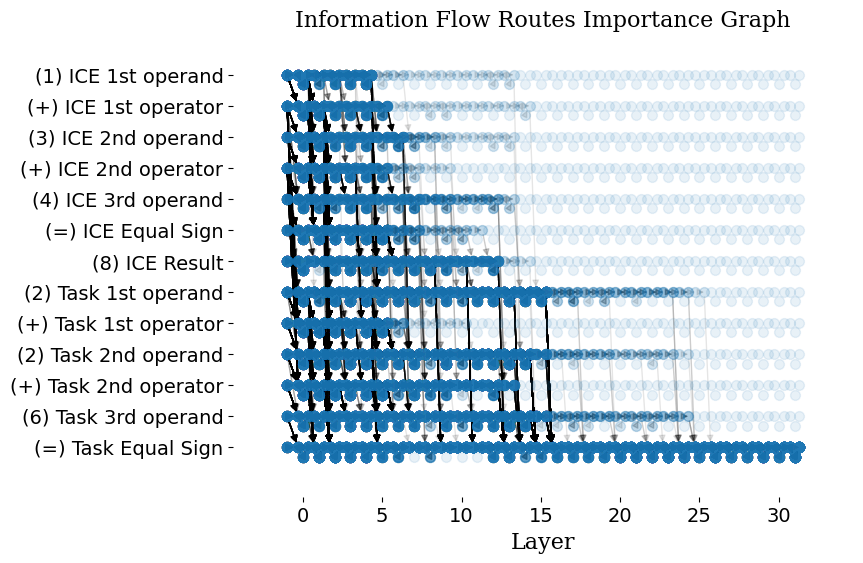

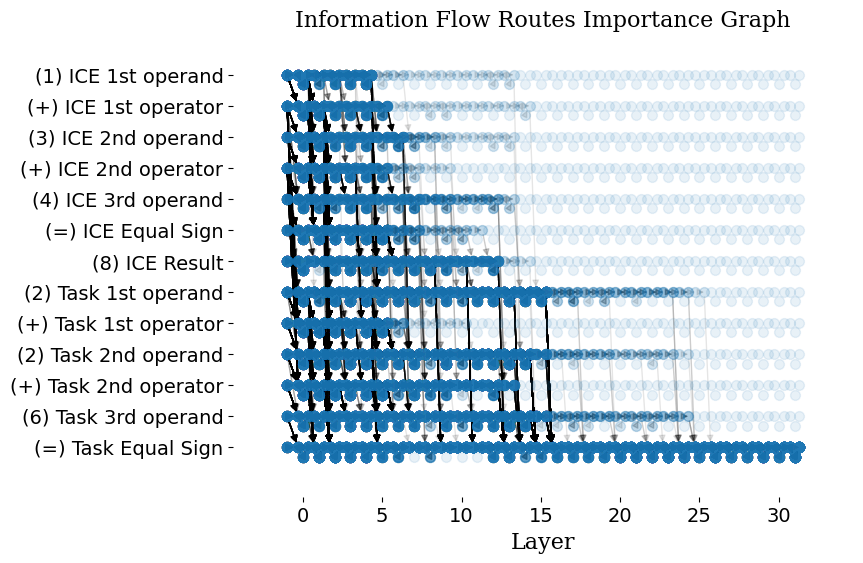

In [15]:
plot_information_flow_graphs(information_flow_graphs_main_nodes, save_path=None)

### Obtain information flow graphs for all thresholds 